In [1]:
import os
import yaml
import nltk
import string
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

/Users/imilyutin/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [107]:
nltk.download(['stopwords', 'punkt', 'wordnet', 'omw-1.4', 'averaged_perceptron_tagger'])
plt.style.use('seaborn')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/imilyutin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/imilyutin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/imilyutin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/imilyutin/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/imilyutin/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [3]:
credentials_file = os.path.abspath(os.path.join('..', 'credentials.yaml'))
with open(credentials_file, 'r') as f:
    credentials = yaml.safe_load(f)

storage_options = {
    'key': credentials['aws']['access_key'],
    'secret': credentials['aws']['secret_access_key']
}

In [4]:
metadata_uri = f's3://{credentials["aws"]["bucket"]}/metadata/metadata_preprocessed.json'
metadata = pd.read_json(metadata_uri, storage_options=storage_options, orient='index')
metadata.head()

,metadata_collected_flg,reviews_collected_flg,original_title,director,poster_url,actors,imdb_recommendations,rating,num_votes,user_review_num,...,original_language,production_company_1,production_company_2,production_company_3,filming_location,filming_country,budget,boxoffice_gross_domestic,boxoffice_gross_opening,boxoffice_gross_worldwide
/title/tt1806913/,True,True,Golmaal Again,Rohit Shetty,https://m.media-amazon.com/images/M/MV5BYmI5Y2...,"{'1': '/name/nm0222426/', '2': '/name/nm045117...","{'1': '/title/tt1562859/', '2': '/title/tt1092...",4.9,9600,79.0,...,Hindi,Mangal Murti Films,Reliance Entertainment,Rohit Shetty Picturez,"Gstaad, Kanton Bern, Switzerland",Switzerland,None,"$1,013,893","$1,013,893","$2,058,098"
/title/tt0367959/,True,True,Hannibal Rising,Peter Webber,https://m.media-amazon.com/images/M/MV5BMTIzMT...,"{'1': '/name/nm0880484/', '2': '/name/nm040697...","{'1': '/title/tt0212985/', '2': '/title/tt0289...",6.1,111000,454.0,...,English,Dino De Laurentiis Company,Quinta Communications,Ingenious Film Partners,Lithuania,Lithuania,"$50,000,000 (estimated)","$27,670,986","$13,051,650","$82,169,884"
/title/tt0445054/,True,True,7 Days,Daniel Grou,https://m.media-amazon.com/images/M/MV5BYmNkMW...,"{'1': '/name/nm0499218/', '2': '/name/nm032072...","{'1': '/title/tt1331291/', '2': '/title/tt1555...",6.5,8100,57.0,...,French,Go Films,None,None,"Québec, Canada",Canada,"CA$3,400,000 (estimated)",None,None,"$1,259"
/title/tt0364517/,True,True,Love Me If You Dare,Yann Samuell,https://m.media-amazon.com/images/M/MV5BZjZhYm...,"{'1': '/name/nm0133899/', '2': '/name/nm018283...","{'1': '/title/tt1440232/', '2': '/title/tt0372...",7.5,70000,117.0,...,French,Nord-Ouest Films,StudioCanal,Artémis Productions,"Liège, Wallonia, Belgium",Belgium,None,"$553,504","$21,546","$8,604,201"
/title/tt0961097/,True,True,A Monster in Paris,Bibo Bergeron,https://m.media-amazon.com/images/M/MV5BMWY2Mz...,"{'1': '/name/nm1342060/', '2': '/name/nm066085...","{'1': '/title/tt0944834/', '2': '/title/tt1181...",6.7,21000,61.0,...,French,EuropaCorp,Bibo Films,France 3 Cinéma,None,None,"€25,000,000 (estimated)",None,None,"$26,710,392"


In [5]:
partition_uri = f's3://{credentials["aws"]["bucket"]}/reviews/reviews_partition_1.csv'
partition = pd.read_csv(
    partition_uri,
    compression='gzip',
    storage_options=storage_options
)
partition = partition.drop('author', axis=1).astype({'review_date': 'datetime64[D]'})
mem = partition.memory_usage(deep=True).sum()/1024/1024
print('Number of reviews:', len(partition))
print(f'Memory usage: {mem:.1f} Mb')
partition.head()

Number of reviews: 242940
Memory usage: 319.6 Mb


,text,rating,title,movie_id,upvotes,total_votes,review_date
0,"Chucky (the murderous doll from ""Child's Play""...",9.0,Silly but fun,/title/tt0144120/,33,40,2006-07-06
1,"They obviously made ""Bride of Chucky"" with the...",10.0,glass ceiling has a new meaning,/title/tt0144120/,17,20,2009-03-21
2,Well my opinion has changed for this one becau...,10.0,Who The (Beep) Is Martha Stewart?(**** Out Of...,/title/tt0144120/,19,22,2012-12-13
3,Clever is the word that comes to mind when I t...,6.0,A rough ride to Hackensack for Chucky and his...,/title/tt0144120/,11,15,2008-10-29
4,Realizing he needs to turn back into human for...,10.0,The best of the series,/title/tt0144120/,11,15,2012-08-23


In [6]:
partition = pd.merge(
    partition,
    metadata[['genre_1', 'genre_2', 'runtime', 'director']].reset_index(),
    left_on='movie_id',
    right_on='index'
)
partition['positive_sentiment'] = partition['rating'] > 5
partition['genres'] = partition['genre_1'] + ', ' + partition['genre_2']
partition.columns

Index(['text', 'rating', 'title', 'movie_id', 'upvotes', 'total_votes',
       'review_date', 'index', 'genre_1', 'genre_2', 'runtime', 'director',
       'genres'],
      dtype='object')

# General

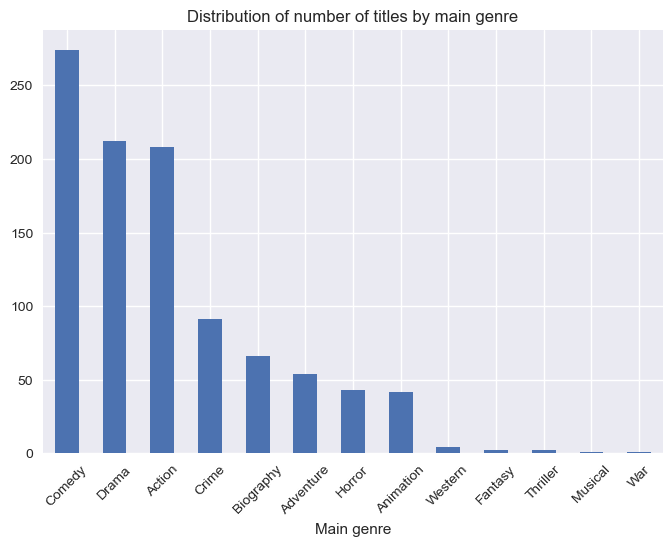

In [7]:
movie_count_by_genres = (
    partition
    .groupby('genre_1')
    ['movie_id']
    .nunique()
    .sort_values(ascending=False)
)

movie_count_by_genres.plot.bar(
    xlabel='Main genre',
    title='Distribution of number of titles by main genre'
)
plt.xticks(rotation=45)
plt.show()

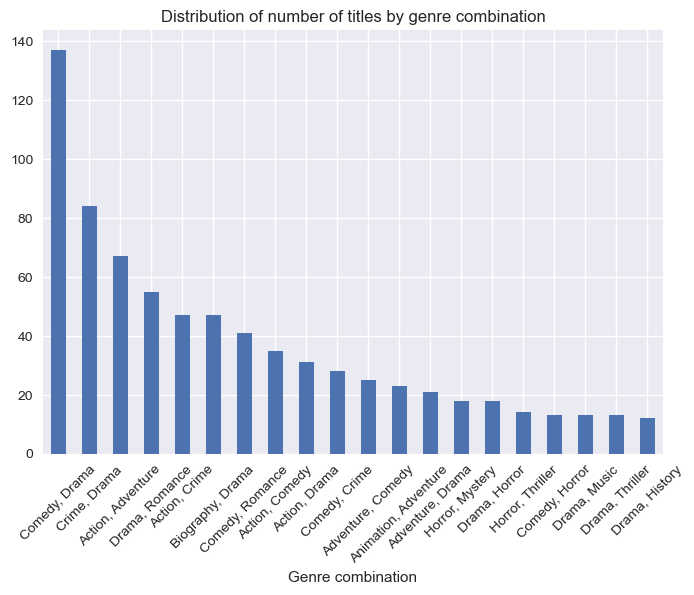

In [8]:
top_genre_comb = 20
movie_count_by_genres_comb = (
    partition
    .groupby('genres')
    ['movie_id']
    .nunique()
    .sort_values(ascending=False)
)

movie_count_by_genres_comb[:top_genre_comb].plot.bar(
    xlabel='Genre combination',
    title='Distribution of number of titles by genre combination'
)
plt.xticks(rotation=45)
plt.show()

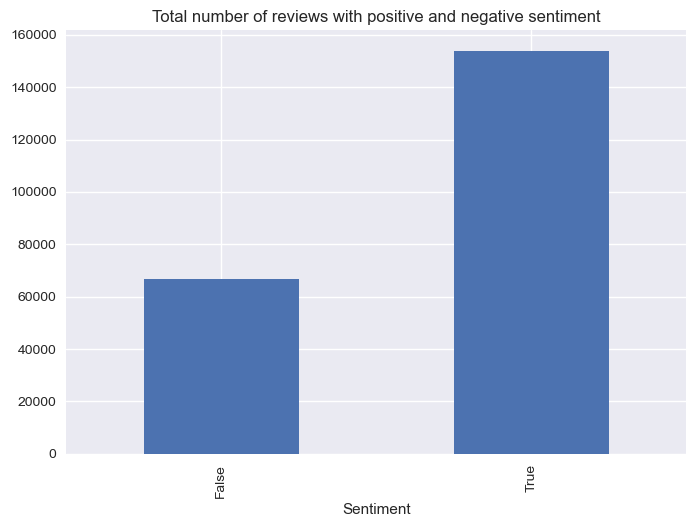

In [143]:
partition.groupby('positive_sentiment')['rating'].count().plot.bar(
    title='Total number of reviews with positive and negative sentiment',
    xlabel='Sentiment'
)
plt.show()

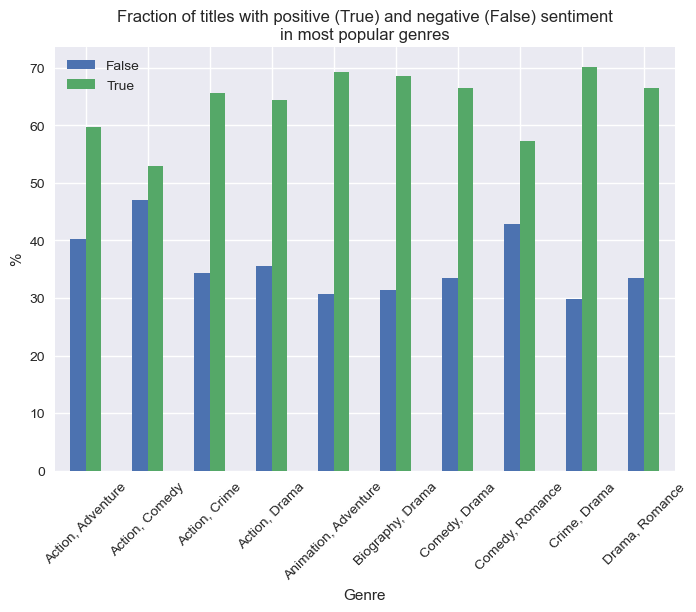

In [169]:
sentiment_stats_by_genre = (
    partition
    .groupby(['genres', 'positive_sentiment'], as_index=False)
    ['movie_id']
    .count()
)
sentiment_stats_by_genre_agg = (
    sentiment_stats_by_genre
    .groupby('genres')
    ['movie_id'].sum()
)
sentiment_stats_by_genre_agg.name = 'total'
sentiment_stats_by_genre = pd.merge(
    sentiment_stats_by_genre,
    sentiment_stats_by_genre_agg,
    left_on='genres',
    right_index=True
)
sentiment_stats_by_genre['positive_sentiment_pct'] = (
    100 * sentiment_stats_by_genre['movie_id']
    / sentiment_stats_by_genre['total']
)
sentiment_stats_by_genre = sentiment_stats_by_genre.sort_values(
    ['total'], ascending=False
)

top_genres = 20
sentiment_stats_by_genre_ = sentiment_stats_by_genre[:top_genres].pivot(
    index='genres', columns='positive_sentiment', values='positive_sentiment_pct'
)
sentiment_stats_by_genre_.plot(
    kind='bar',
    ylabel='%',
    xlabel='Genre',
    title=(
        'Fraction of titles with positive (True) and negative (False) sentiment\n'
        'in most popular genres'
    )
)
plt.xticks(rotation=45)
plt.legend(title='')
plt.show()

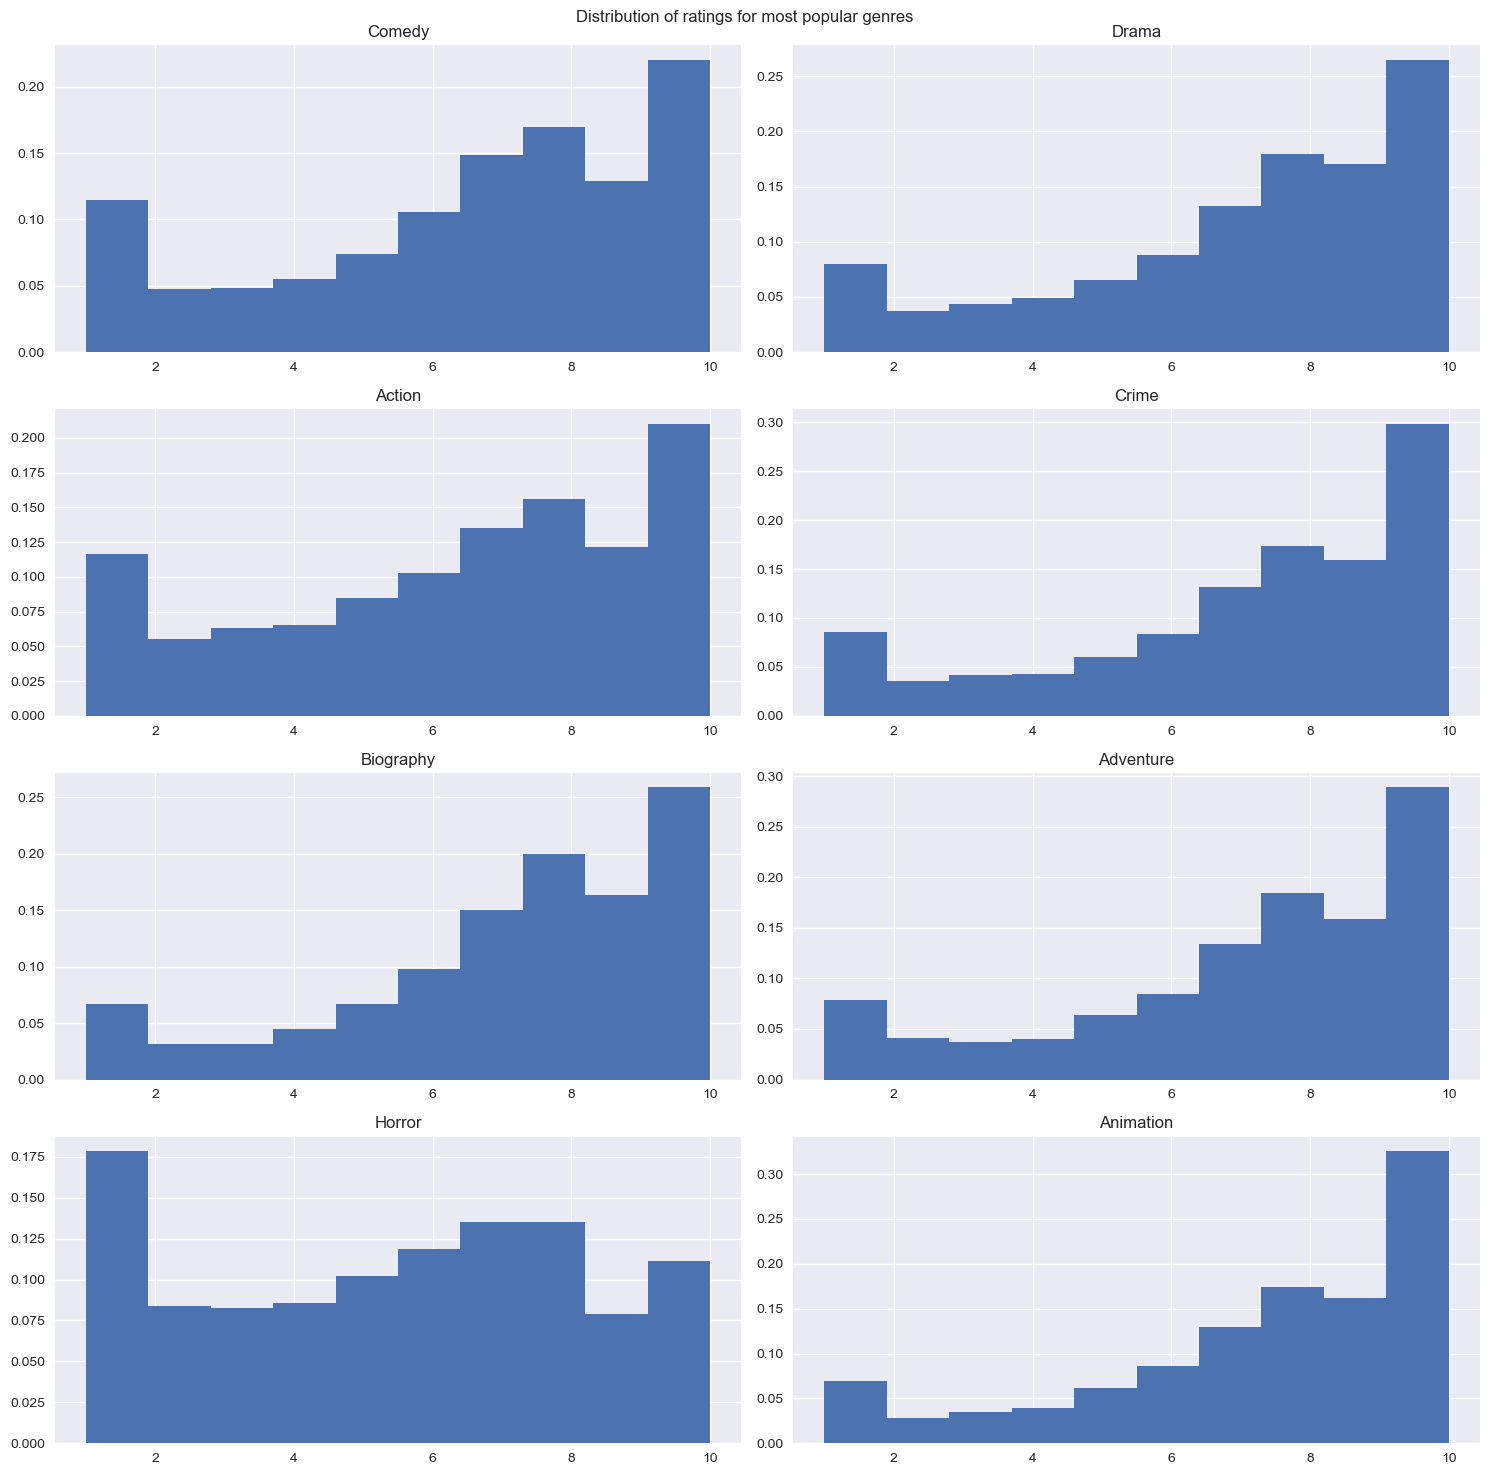

In [9]:
fig, ax = plt.subplots(4, 2, tight_layout=True, figsize=(15, 15))
ax = ax.flatten()
for i, genre in enumerate(movie_count_by_genres.index[:8]):
    partition[partition['genre_1'] == genre]['rating'].hist(bins=10, density=True, ax=ax[i])
    ax[i].set_title(genre)
fig.suptitle('Distribution of ratings for most popular genres')
plt.show()

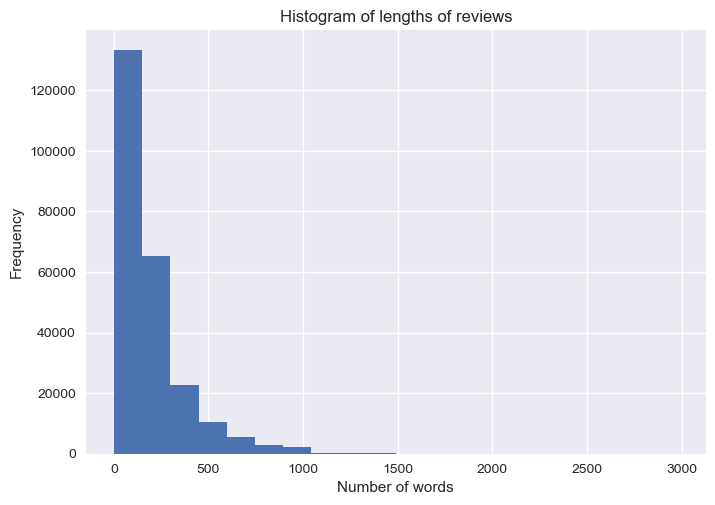

In [10]:
review_len = partition['text'].str.split().apply(len)
review_len.plot.hist(bins=20, title='Histogram of lengths of reviews')
plt.xlabel('Number of words')
plt.show()

# Words distribution

In [173]:
partition_sample = (
    partition[~partition['rating'].isna()]
    .sort_values(['positive_sentiment', 'total_votes'])
    .groupby('positive_sentiment')
    .tail(5000)
)
partition_sample

,text,rating,title,movie_id,upvotes,total_votes,review_date,index,genre_1,genre_2,runtime,director,genres,positive_sentiment
231528,ZERO chemistry between the lead actors. My soc...,2.0,Here's the problem...,/title/tt1563742/,43,62,2020-04-13,/title/tt1563742/,Comedy,Romance,112,Rob Greenberg,"Comedy, Romance",False
231575,So this movie is terrible i was miserable whil...,2.0,horrible,/title/tt1563742/,29,62,2018-05-15,/title/tt1563742/,Comedy,Romance,112,Rob Greenberg,"Comedy, Romance",False
231593,"If you waste your time and money to see this, ...",1.0,One of the worst movies of all time,/title/tt1563742/,24,62,2018-05-05,/title/tt1563742/,Comedy,Romance,112,Rob Greenberg,"Comedy, Romance",False
237444,"""Crash"" is not the best picture of the year; t...",1.0,Despicable,/title/tt0375679/,36,62,2006-03-06,/title/tt0375679/,Crime,Drama,112,Paul Haggis,"Crime, Drama",False
237446,I don't think this movie deserves to be nomine...,5.0,Best Motion Picture of the Year? C'Mon!,/title/tt0375679/,34,62,2006-02-03,/title/tt0375679/,Crime,Drama,112,Paul Haggis,"Crime, Drama",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5372,I expected to dislike this movie because of ho...,10.0,So good!,/title/tt4154664/,1230,2521,2019-03-07,/title/tt4154664/,Action,Adventure,123,Anna Boden,"Action, Adventure",True
100453,I don't know what's going on with all the nega...,9.0,Very fun movie,/title/tt1270797/,2014,2611,2018-10-03,/title/tt1270797/,Action,Adventure,112,Ruben Fleischer,"Action, Adventure",True
100470,We just came out of the theatre and I can hone...,8.0,Do yourself a favour...ignore the critics!,/title/tt1270797/,2186,2914,2018-10-03,/title/tt1270797/,Action,Adventure,112,Ruben Fleischer,"Action, Adventure",True
5060,8/10. It was a very enjoyable origin story. I ...,8.0,THE best? No. Enjoyable and ties nicely into ...,/title/tt4154664/,1850,3471,2019-03-08,/title/tt4154664/,Action,Adventure,123,Anna Boden,"Action, Adventure",True


In [174]:
stopwords = set(nltk.corpus.stopwords.words("english"))
punctuation = {p for p in string.punctuation}
other = {"'s", "``", "''", "n't", "...", "--", "-", "'ve", "`ve"}
stop_tokens = stopwords.union(punctuation).union(other)

In [188]:
# import spacy
# nlp = spacy.load("en_core_web_sm")

ModuleNotFoundError: No module named 'spacy'

In [184]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet

In [189]:
TAGS = {
    "J": wordnet.ADJ,
    "N": wordnet.NOUN,
    "V": wordnet.VERB,
    "R": wordnet.ADV
}
lemmatizer = WordNetLemmatizer()

def get_lemma(lemmatizer, word, nltk_tag):
    if nltk_tag[0] not in TAGS.keys():
        return lemmatizer.lemmatize(word)
    return lemmatizer.lemmatize(word, TAGS[nltk_tag[0]])

sentiment_tokens = {}
for s in tqdm([0, 1]):
    part = partition_sample[
        partition_sample['positive_sentiment'] == s
    ]
    corpus = ' '.join(part['text'].str.lower())
    tokens_raw = nltk.tokenize.word_tokenize(corpus)
    tokens_pos = nltk.pos_tag(tokens_raw)
    sentiment_tokens[s] = [
        get_lemma(lemmatizer, token, tag)
        for token, tag in tokens_pos
        if (token not in stop_tokens)
    ]

100%|██████████| 2/2 [03:52<00:00, 116.44s/it]


In [190]:
sentiment_tokens.keys()

dict_keys([0, 1])

In [192]:
sentiment_fd = {
    g: nltk.FreqDist(tokens)
    for g, tokens in sentiment_tokens.items()
}
print(sentiment_fd.keys())

dict_keys([0, 1])


In [193]:
top_n = 30
top_common_words = set()
for s, fd in sentiment_fd.items():
    for w in fd.most_common()[:top_n]:
        top_common_words.add(w[0])

print(top_common_words)

{'love', 'also', 'great', 'even', 'story', 'much', 'go', 'would', 'scene', 'take', 'character', 'first', 'give', 'bad', 'one', 'people', 'like', 'watch', 'could', 'see', 'well', 'make', 'movie', 'end', 'say', 'good', 'know', 'look', 'film', 'really', 'time', 'think', 'way', 'get'}


In [194]:
top_n_popular = 20
relevant_sentiment_fd = {}
for g, fd in sentiment_fd.items():
    counter = 0
    words = []
    for el, cnt in fd.most_common():
        if el not in top_common_words:
            words.append((el, cnt))
            counter += 1

        if counter == top_n_popular:
            relevant_sentiment_fd[g] = words
            break

print(relevant_sentiment_fd.keys())

dict_keys([0, 1])


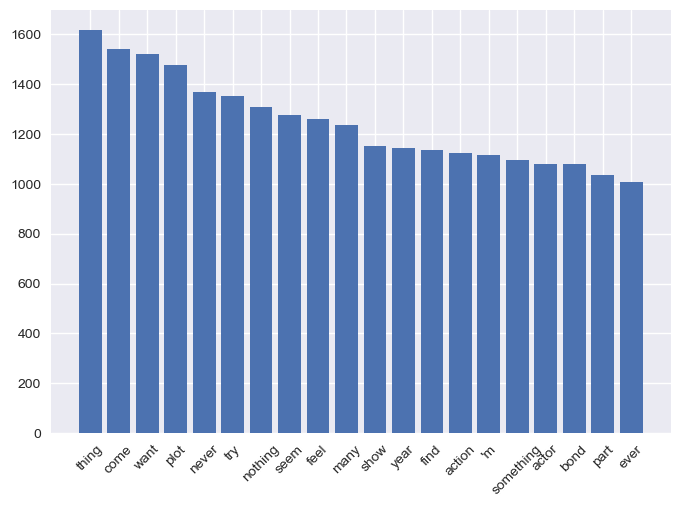

In [196]:
l = relevant_sentiment_fd[0]
x, y = zip(*l)

#fig, ax = plt.subplots()
plt.bar(x, y)
plt.xticks(rotation=45)
plt.show()